In [1]:
import polars as pl
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from kshape_core_gpu import KShapeClusteringGPU
import sys

MAC_DIR = '/Users/igwanhyeong/PycharmProjects/data_research/data/'
WINDOW_DIR = 'C:/Users/USER/PycharmProjects/research/data/'

if sys.platform == 'win32':
    DIR = WINDOW_DIR
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.version.cuda)
    print(torch.__version__)
    print(torch.cuda.get_device_name(0))
    print(torch.__version__)
else:
    DIR = MAC_DIR

tb_bas_oper_part_mst = (pl.read_parquet(DIR + 'tb_bas_oper_part_mst.parquet')
                        .select(['OPER_PART_NO', 'OPER_PART_NM'])
                        .rename({'OPER_PART_NO': 'oper_part_no', 'OPER_PART_NM': 'oper_part_nm'}))
tb_dyn_fcst_demand_sellout = (pl.read_parquet(DIR + 'tb_dyn_fcst_dmnd_sellout.parquet')
                              .select(['PART_NO', 'DMND_QTY', 'DMND_DT', 'OPER_PART_NO'])
                              .rename({'PART_NO': 'part_no', 'OPER_PART_NO': 'oper_part_no', 'DMND_DT': 'demand_dt', 'DMND_QTY': 'demand_qty'})
                              .select(['part_no', 'oper_part_no', 'demand_dt', 'demand_qty']))

True
1
12.8
2.9.0.dev20250716+cu128
NVIDIA GeForce RTX 5080
2.9.0.dev20250716+cu128


In [2]:
target_df = (tb_dyn_fcst_demand_sellout
    .with_columns(
        (pl.col("demand_dt").cast(pl.Int64) // 100).alias("demand_yyyymm")
    )
    .join(tb_bas_oper_part_mst, on = 'oper_part_no', how = 'left')
    .group_by(['oper_part_no', 'demand_yyyymm'])
    .agg(pl.col('demand_qty').sum().alias('demand_qty'))
    .sort(['oper_part_no', 'demand_yyyymm'])
    .with_columns(pl.col('demand_yyyymm').cast(pl.Utf8).str.strptime(pl.Date, '%Y%m').alias('month'))
)


min_month = target_df.select(pl.col('month').min())[0, 0]
max_month = target_df.select(pl.col('month').max())[0, 0]

full_months = pl.date_range(start = min_month, end = max_month, interval = '1mo', eager = True)
month_df = pl.DataFrame({'month': full_months})
unique_parts = target_df.select(pl.col('oper_part_no').unique())
base = unique_parts.join(month_df, how = 'cross')

aligned_df = (base
                .join(
                    target_df.select(['oper_part_no', 'month', 'demand_qty']),
                    on = ['oper_part_no', 'month'], how = 'left')
                .with_columns(pl.col('demand_qty').fill_null(0.0))
                .pivot(
                    values = 'demand_qty',
                    on = 'month',
                    aggregate_function = 'first'
                )
              )

In [3]:
aligned_df

oper_part_no,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,…,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01,2025-08-01,2025-09-01,2025-10-01,2025-11-01,2025-12-01,2026-01-01,2026-02-01,2026-03-01,2026-04-01,2026-05-01,2026-06-01,2026-07-01,2026-08-01,2026-09-01,2026-10-01,2026-11-01,2026-12-01,2027-01-01,2027-02-01
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""E5700-74122""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""CF11-0269A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""P6270-74071""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""81866484""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
"""P6270-47214""",0.0,80.0,2.0,84.0,92.0,176.0,31.0,3.0,0.0,0.0,0.0,0.0,14.0,71.0,4.0,80.0,71.0,166.0,77.0,0.0,0.0,6.0,48.0,0.0,25.0,112.0,25.0,83.0,60.0,94.0,7.0,3.0,5.0,0.0,0.0,2.0,…,0.0,75.0,41.0,68.0,19.0,5.0,0.0,0.0,0.0,6.0,0.0,58.0,0.0,93.0,8.0,73.0,33.0,6.0,0.0,0.0,0.0,0.0,0.0,89.0,0.0,14.0,26.0,47.0,32.0,0.0,0.0,0.0,0.0,0.0,40.0,20.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""T5715-44611""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""37650-4317-0""",0.0,36.0,1.0,17.0,18.0,19.0,17.0,65.0,5.0,101.0,14.0,12.0,11.0,13.0,15.0,5.0,17.0,23.0,25.0,31.0,10.0,102.0,5.0,26.0,65.0,0.0,10.0,23.0,14.0,6.0,30.0,5.0,40.0,67.0,5.0,11.0,…,5.0,5.0,19.0,52.0,27.0,21.0,21.0,26.0,65.0,15.0,2.0,22.0,40.0,31.0,34.0,4.0,37.0,17.0,20.0,57.0,1.0,15.0,21.0,30.0,60.0,56.0,19.0,38.0,37.0,10.0,20.0,81.0,36.0,10.0,41.0,85.0,5.0
"""C7220-68562""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
part_numbers = aligned_df.get_column('oper_part_no')
X_np = aligned_df.select(pl.all().exclude("oper_part_no")).to_numpy()
X_tensor = torch.tensor(X_np, dtype=torch.float32).unsqueeze(-1)  # shape (N, T, 1)

In [5]:
model = KShapeClusteringGPU(n_clusters=5, centroid_init = 'random', max_iter=100)
model.fit(X_tensor)

labels = model.labels_
centroids = model.centroids_

result = pl.DataFrame({
    'oper_part_no': part_numbers,
    'cluster_label': labels.astype(int)
})

result

KShape Training: 100%|██████████| 100/100 [2:31:55<00:00, 91.15s/it] 
5it [00:08,  1.69s/it]


oper_part_no,cluster_label
str,i32
"""E5700-74122""",2
"""CF11-0269A""",2
"""P6270-74071""",0
"""81866484""",0
"""P6270-47214""",4
…,…
"""T5715-44611""",0
"""37650-4317-0""",0
"""C7220-68562""",2


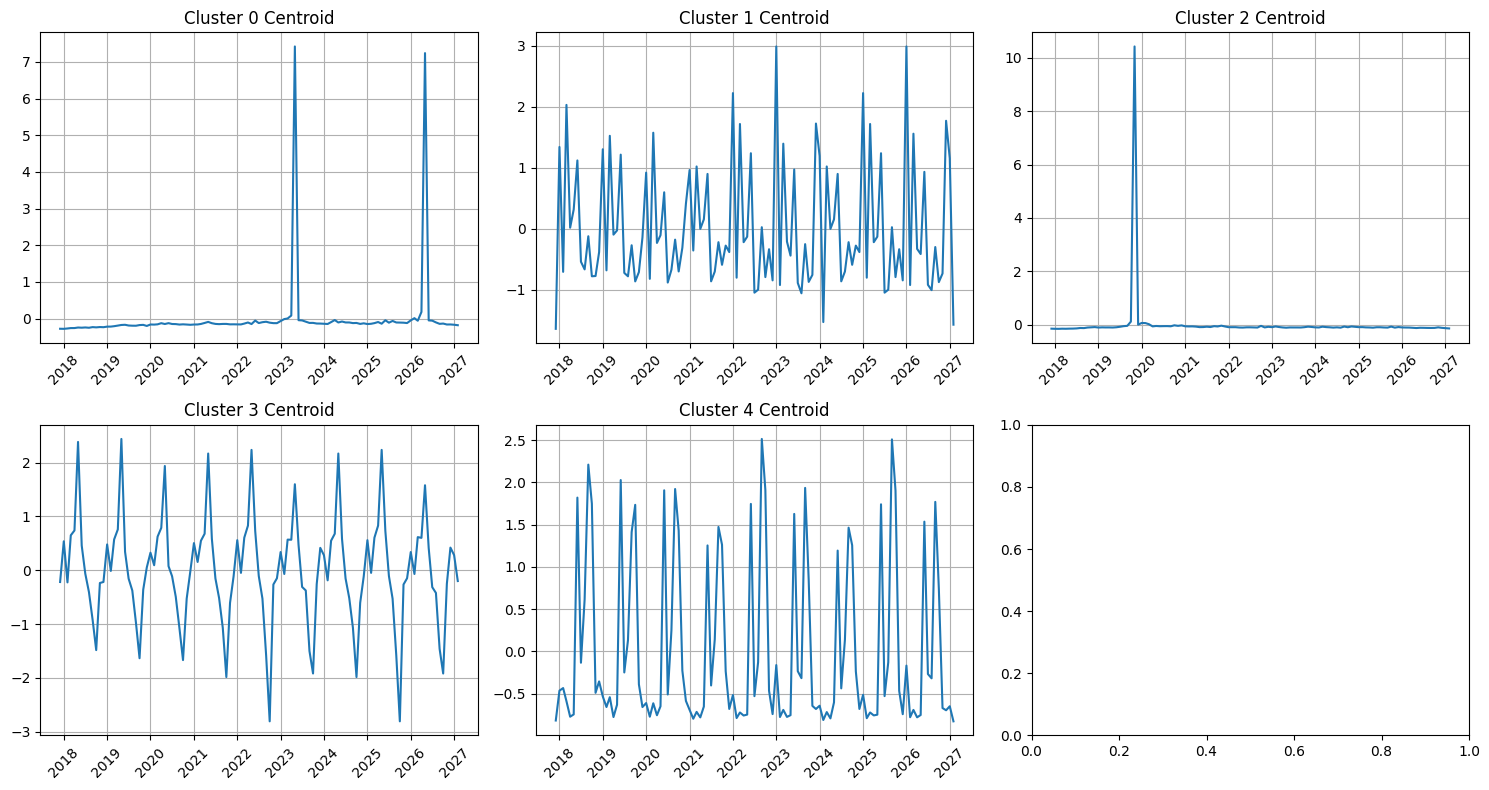

In [7]:
import matplotlib.pyplot as plt

def plot_kshape_centroids(model, full_months, max_cols=3):
    """
    model: 학습된 KShapeClusteringGPU 모델
    full_months: pivot 시 사용한 월별 컬럼 리스트 (Datetime 또는 문자열 가능)
    """
    k = model.n_clusters
    n_cols = min(k, max_cols)
    n_rows = (k + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

    for i, ax in enumerate(axes.flat[:k]):
        centroid = model.centroids_[i].cpu().squeeze().numpy()
        ax.plot(full_months, centroid)
        ax.set_title(f"Cluster {i} Centroid")
        ax.tick_params(axis='x', labelrotation=45)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

plot_kshape_centroids(model, full_months=full_months)


In [35]:
aligned_df[44, 1:]

2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,…,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01,2025-08-01,2025-09-01,2025-10-01,2025-11-01,2025-12-01,2026-01-01,2026-02-01,2026-03-01,2026-04-01,2026-05-01,2026-06-01,2026-07-01,2026-08-01,2026-09-01,2026-10-01,2026-11-01,2026-12-01,2027-01-01,2027-02-01
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,125.0,12.0,31.0,0.0,30.0,136.0,95.0,45.0,506.0,245.0,0.0,71.0,65.0,9.0,10.0,10.0,60.0,250.0,11.0,102.0,296.0,103.0,14.0,0.0,50.0,0.0,0.0,20.0,7.0,220.0,15.0,82.0,244.0,133.0,1.0,80.0,…,0.0,30.0,2.0,13.0,206.0,7.0,29.0,221.0,257.0,86.0,0.0,105.0,5.0,60.0,0.0,5.0,380.0,70.0,66.0,412.0,149.0,82.0,11.0,267.0,0.0,20.0,15.0,0.0,200.0,38.0,3.0,148.0,118.0,2.0,55.0,10.0,0.0


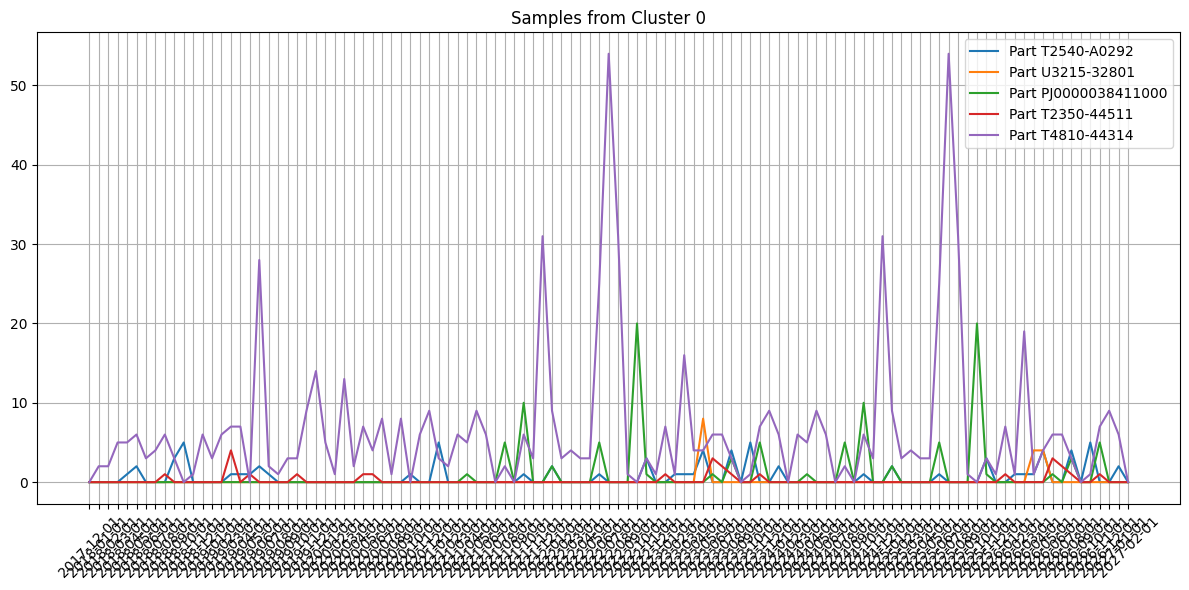

In [41]:
import numpy as np
def plot_cluster_samples(model, pivot_df, cluster_id, full_months, n_samples=5):
    part_numbers = pivot_df["oper_part_no"].values
    member_indices = [i for i, label in enumerate(model.labels_) if label == cluster_id]

    if len(member_indices) == 0:
        print(f"No members in cluster {cluster_id}")
        return

    chosen = np.random.choice(member_indices, size=min(n_samples, len(member_indices)), replace=False)

    # 🛠 full_months 컬럼명을 문자열로 변환 (필요시)
    full_months = [str(col) for col in full_months]
    pivot_df.columns = pivot_df.columns.astype(str)

    plt.figure(figsize=(12, 6))
    for idx in chosen:
        y = pivot_df.loc[idx, full_months].values.astype(float)
        plt.plot(full_months, y, label=f"Part {part_numbers[idx]}")

    plt.title(f"Samples from Cluster {cluster_id}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 사용 예시
plot_cluster_samples(model, aligned_df.to_pandas(), cluster_id=0, full_months=full_months)

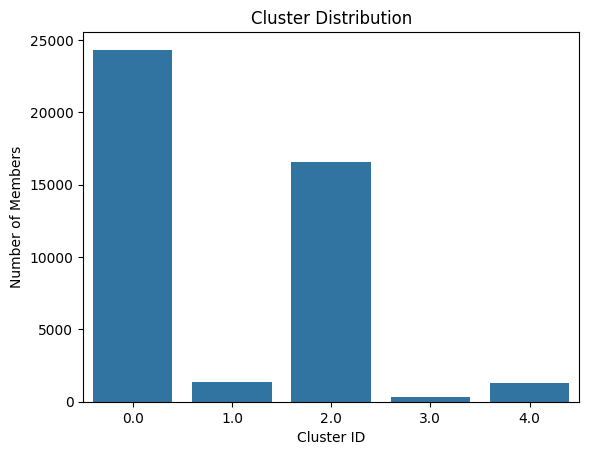

In [12]:
import seaborn as sns

def plot_cluster_distribution(model):
    sns.countplot(x=model.labels_)
    plt.title("Cluster Distribution")
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Members")
    plt.show()

plot_cluster_distribution(model)